In [1]:
import torch
torch.cuda.manual_seed(0)
# 为当前GPU设置随机种子，因为神经网络初始化是随机的，设置一个确定的随机种子可以确保结果相同
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

import os, sys, glob, shutil, json
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class SVHNDataset(Dataset):
    def __init__(self, img_path, img_label, transform=None):
        self.img_path = img_path
        self.img_label = img_label
        if transform is not None:
            self.transform = transform
        else:
            self.transform = None
    
    def __getitem__(self, index):
        img = Image.open(self.img_path[index]).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        
        # 假设最长字符为5个, 提供的数据集中0为0（原数据集中0为类别10），所以我们可以用10来表示空字符串
        lbl = np.array(self.img_label[index], dtype=np.int)
        lbl = list(lbl) + (6 - len(lbl)) * [10]

        return img, torch.from_numpy(np.array(lbl[:6]))
    
    def __len__(self):
        return len(self.img_path)

train_path = glob.glob(r'data\mchar_train\*.png')
# glob库读取所有文件
train_path.sort()
train_json = json.load(open(r'data\mchar_train.json'))
train_label = [train_json[x]['label'] for x in train_json]

data = SVHNDataset(train_path, train_label, transforms.Compose([
    # 缩放到固定尺寸 PIL的resize函数（可选算法）
    transforms.Resize((64, 128)),
    # 随机颜色变换（4个参数 亮度 对比度 饱和度 色相）
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
    # 加入随机旋转（输入的是旋转的度数，从-5度到5度）
    transforms.RandomRotation(5),
    # 将图片转换为pytorch tensor
    transforms.ToTensor(),
    # 将图像像素归一化（对每个通道做z-score）做了之后效果不好
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))

train_loader = torch.utils.data.DataLoader(data, batch_size=192, shuffle=False)

### 定义一个简单的CNN模型

In [ ]:
class SVHN_Model1(nn.Module):
    def __init__(self):
        super(SVHN_Model1, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2)),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2)),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(32*3*7, 11)
        self.fc2 = nn.Linear(32*3*7, 11)
        self.fc3 = nn.Linear(32*3*7, 11)
        self.fc4 = nn.Linear(32*3*7, 11)
        self.fc5 = nn.Linear(32*3*7, 11)
        self.fc6 = nn.Linear(32*3*7, 11)

    def forward(self, img):
        fout = self.cnn(img)
        fout = fout.view(fout.shape[0], -1)
        c1 = self.fc1(fout)
        c2 = self.fc2(fout)
        c3 = self.fc3(fout)
        c4 = self.fc4(fout)
        c5 = self.fc5(fout)
        c6 = self.fc6(fout)
        return c1, c2, c3, c4, c5, c6
    
model = SVHN_Model1()
if torch.cuda.is_available():
    model = model.cuda()

### 训练代码

In [ ]:
lr = 0.005
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr)

loss_plot, c0_plot = [], []

for epoch in range(10):
    for data in train_loader:
        if torch.cuda.is_available():
            data[0] = data[0].cuda()
            data[1] = data[1].cuda()
        c0, c1, c2, c3, c4, c5 = model(data[0])
        loss = criterion(c0, data[1][:, 0].long()) + \
                criterion(c1, data[1][:, 1].long()) + \
                criterion(c2, data[1][:, 2].long()) + \
                criterion(c3, data[1][:, 3].long()) + \
                criterion(c4, data[1][:, 4].long()) + \
                criterion(c5, data[1][:, 5].long())
        loss /= 6
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_plot.append(loss.item())
        c0_plot.append((c0.argmax(1) == data[1][:, 0]).sum().item()*1.0 / c0.shape[0])
    
    print(epoch)

In [32]:
c0_plot[-10:]

[0.40625,
 0.34375,
 0.3125,
 0.21875,
 0.15625,
 0.21875,
 0.25,
 0.25,
 0.25,
 0.40625]

In [8]:
torch.cuda.get_device_name()

'GeForce GTX 1050 Ti'

In [38]:
a = [1,2,3]
a[:-1]

[1, 2]

In [3]:
class SVHN_Model2(nn.Module):
    def __init__(self):
        super(SVHN_Model2, self).__init__()
        
        model_conv = models.resnet18(pretrained=True)
        model_conv.avgpool = nn.AdaptiveAvgPool2d(1)
        model_conv = nn.Sequential(*list(model_conv.children())[:-1])
        
        self.cnn = model_conv
        self.fc0 = nn.Linear(512, 11)
        self.fc1 = nn.Linear(512, 11)
        self.fc2 = nn.Linear(512, 11)
        self.fc3 = nn.Linear(512, 11)
        self.fc4 = nn.Linear(512, 11)
        self.fc5 = nn.Linear(512, 11)
   
    def forward(self, img):
        feat = self.cnn(img)
        # print(feat.shape)
        feat = feat.view(feat.shape[0], -1)
        c0 = self.fc0(feat)
        c1 = self.fc1(feat)
        c2 = self.fc2(feat)
        c3 = self.fc3(feat)
        c4 = self.fc4(feat)
        c5 = self.fc5(feat)
        return c0, c1, c2, c3, c4, c5

model = SVHN_Model2()
if torch.cuda.is_available():
    model = model.cuda()

In [5]:
model.load_state_dict(torch.load('model2.pt'))

<All keys matched successfully>

In [6]:
lr = 0.005
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr)

loss_plot, c0_plot = [], []

for epoch in range(1):
    for data in train_loader:
        if torch.cuda.is_available():
            data[0] = data[0].cuda()
            data[1] = data[1].cuda().long()
        c0, c1, c2, c3, c4, c5 = model(data[0])
        loss = criterion(c0, data[1][:, 0]) + \
                criterion(c1, data[1][:, 1]) + \
                criterion(c2, data[1][:, 2]) + \
                criterion(c3, data[1][:, 3]) + \
                criterion(c4, data[1][:, 4]) + \
                criterion(c5, data[1][:, 5])
        loss /= 6
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_plot.append(loss.item())
        c0_plot.append((c0.argmax(1) == data[1][:, 0]).sum().item()*1.0 / c0.shape[0])
    
        print(epoch)
        print(c0_plot[-1])

0
0.2760416666666667
0
0.3333333333333333
0
0.2916666666666667
0
0.28125
0
0.2708333333333333
0
0.28125
0
0.265625
0
0.22395833333333334
0
0.20833333333333334
0
0.2708333333333333
0
0.203125
0
0.2760416666666667
0
0.24479166666666666
0
0.3072916666666667
0
0.2864583333333333
0
0.21354166666666666
0
0.28125
0
0.265625
0
0.2864583333333333
0
0.23958333333333334
0
0.28125
0
0.18229166666666666
0
0.22395833333333334
0
0.3177083333333333
0
0.2916666666666667
0
0.296875
0
0.2552083333333333
0
0.3125
0
0.3125
0
0.296875
0
0.2604166666666667
0
0.2552083333333333
0
0.2760416666666667
0
0.3177083333333333
0
0.25
0
0.23958333333333334
0
0.265625
0
0.3020833333333333
0
0.21875
0
0.2916666666666667
0
0.3072916666666667
0
0.2604166666666667
0
0.2604166666666667
0
0.2916666666666667
0
0.21875
0
0.2760416666666667
0
0.22916666666666666
0
0.2916666666666667
0
0.28125
0
0.2916666666666667
0
0.3020833333333333
0
0.265625
0
0.2916666666666667
0
0.2604166666666667
0
0.2864583333333333
0
0.24479166666666666

In [13]:
sum(c0_plot)/98

0.4365965136054422

In [7]:
len(train_loader)

157

In [12]:
938*32

30016

In [23]:
c0_plot?

Type:        list
String form: [0.2708333333333333, 0.3333333333333333, 0.28125, 0.2760416666666667, 0.18229166666666666, 0.2187 <...> .2864583333333333, 0.20833333333333334, 0.3072916666666667, 0.2760416666666667, 0.234375, 0.3125]
Length:      157
Docstring:  
Built-in mutable sequence.

If no argument is given, the constructor creates a new empty list.
The argument must be an iterable if specified.


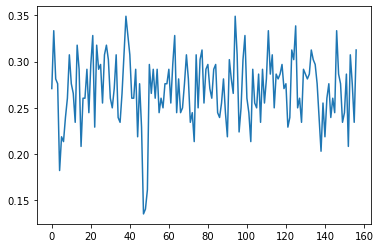

In [24]:
x = [i for i in range(len(c0_plot))]
plt.plot(x, c0_plot)

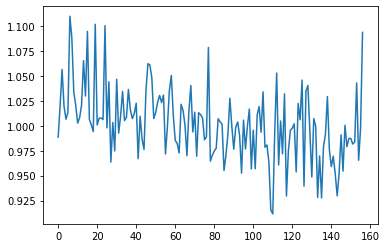

In [25]:
plt.plot(x, loss_plot)

In [11]:
def train(model, train_loader):
    lr = 0.005
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr)

    loss_plot, c0_plot = [], []
   
    for data in train_loader:
        if torch.cuda.is_available():
            data[0] = data[0].cuda()
            data[1] = data[1].cuda().long()
        c0, c1, c2, c3, c4, c5 = model(data[0])
        loss = criterion(c0, data[1][:, 0]) + \
                criterion(c1, data[1][:, 1]) + \
                criterion(c2, data[1][:, 2]) + \
                criterion(c3, data[1][:, 3]) + \
                criterion(c4, data[1][:, 4]) + \
                criterion(c5, data[1][:, 5])
        loss /= 6
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_plot.append(loss.item())
        c0_plot.append((c0.argmax(1) == data[1][:, 0]).sum().item()*1.0 / c0.shape[0])
        

In [9]:
import cProfile as cpro

In [12]:
cpro.run("train(model, train_loader)", filename='result.out')

In [26]:
torch.save(model.state_dict(), 'model2.pt')

In [9]:
import pstats
from pstats import SortKey
p = pstats.Stats('result.out')
p.strip_dirs().sort_stats(SortKey.TIME).print_stats(10)

Mon May 25 23:10:42 2020    result.out

         16923788 function calls (16819333 primitive calls) in 490.308 seconds

   Ordered by: internal time
   List reduced from 307 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   444390  264.941    0.001  264.941    0.001 {method 'read' of '_io.BufferedReader' objects}
    30000   60.286    0.002   60.286    0.002 {built-in method io.open}
      315   36.667    0.116   36.667    0.116 {method 'item' of 'torch._C._TensorBase' objects}
   180000   20.499    0.000   20.499    0.000 {method 'convert' of 'ImagingCore' objects}
    58125   13.637    0.000   13.637    0.000 {method 'decode' of 'ImagingDecoder' objects}
     3140   10.352    0.003   10.352    0.003 {built-in method conv2d}
    90000    5.982    0.000    5.982    0.000 {built-in method PIL._imaging.blend}
      157    5.421    0.035    5.421    0.035 {method 'run_backward' of 'torch._C._EngineBase' objects}
    29998    4.400   

In [19]:
c0_plot[-5:]

NameError: name 'c0_plot' is not defined